1 Upload & unzip once at the top

In [ ]:
# 🚀 Install core stack (Torch + Transformers + PEFT + bitsandbytes)
!pip -q install --upgrade --index-url https://download.pytorch.org/whl/cu121 \
    torch torchvision torchaudio
!pip -q install transformers==4.41.0 bitsandbytes==0.42.0 peft==0.10.0 accelerate sentencepiece pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 112.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 📚 Imports
import torch, pandas as pd, numpy as np, json, os, zipfile, shutil
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
from IPython.display import display

 Upload the deberta_lora_adapter folder (zip or individual files)

In [ ]:
from google.colab import files
#uploaded = files.upload()  # upload zip or files, C:\Users\josep\OneDrive\Harrisburg University\Anly699\fine_tuned_model\deberta_ep56
                           # C:\Users\josep\OneDrive\Harrisburg University\Anly699\training data\sample_1000_labelled_firstpass_ready4colab
fname = "deberta_ep56.zip"

if fname.endswith('.zip'):
    with zipfile.ZipFile(fname, 'r') as z:
        z.extractall('.')
    ADAPTER_DIR = fname.replace('.zip', '')
else:
    ADAPTER_DIR = 'deberta_lora_adapter'
    os.makedirs(ADAPTER_DIR, exist_ok=True)
    for fn in uploaded.keys():
        shutil.move(fn, os.path.join(ADAPTER_DIR, fn))
ADAPTER_DIR = os.path.abspath('checkpoint-3192')

model-loading

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
import torch

BASE_MODEL  = "yangheng/deberta-v3-base-absa-v1.1"
#ADAPTER_DIR = "deberta_lora_adapter"          # your uploaded folder

tokenizer = AutoTokenizer.from_pretrained(ADAPTER_DIR)

# ① load in fp16 on CPU (fits in RAM; still fast)
base = AutoModelForSequenceClassification.from_pretrained(
        BASE_MODEL,
        torch_dtype=torch.float16,    # half-precision weights
        low_cpu_mem_usage=False       # standard loader path
)

# ② move whole model to GPU in one call
base = base.to("cuda")

# ③ merge LoRA adapter
model = PeftModel.from_pretrained(base, ADAPTER_DIR).eval()

print("Loaded: first param on", next(model.parameters()).device,
      "| dtype", next(model.parameters()).dtype)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded: first param on cuda:0 | dtype torch.float16


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DebertaV2ForSequenceClassification(
      (deberta): DebertaV2Model(
        (embeddings): DebertaV2Embeddings(
          (word_embeddings): Embedding(128100, 768, padding_idx=0)
          (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
          (dropout): StableDropout()
        )
        (encoder): DebertaV2Encoder(
          (layer): ModuleList(
            (0-11): 12 x DebertaV2Layer(
              (attention): DebertaV2Attention(
                (self): DisentangledSelfAttention(
                  (query_proj): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=32, bias=False)
                    

**Build a SHAP explainer**

In [ ]:
import shap, numpy as np

# 3-A  helper: batch-predict logits
def predict_probs(texts):
    # ⬇️ 1.  Convert SHAP’s object-array → Python list
    if isinstance(texts, np.ndarray):          # SHAP hands an ndarray
        texts = texts.tolist()                 # → list[object]
    # ⬇️ 2.  Make sure each element is a str (join tokens if needed)
    if texts and isinstance(texts[0], list):   # e.g. ['Sh', '##ip', …]
        texts = ["".join(toks) for toks in texts]

    toks = tokenizer(texts,
                     padding=True,
                     truncation=True,
                     max_length=256,
                     return_tensors='pt').to(model.device)

    with torch.no_grad():
        logits = model(**toks).logits          # (batch, 3)
    return logits.cpu().numpy()

# 3-B  choose small background set (20 random short sentences)
background = ["Example sentence."] * 20   # or pick 20 real reviews

explainer = shap.Explainer(
    predict_probs,
    masker=shap.maskers.Text(tokenizer),
    algorithm="partition",
    output_names=["Negative","Neutral","Positive"],
    seed=42
)
print("SHAP explainer ready.")


SHAP explainer ready.


**Run explanaitions**

In [ ]:
sample_texts = [
    "Shipping was late and the box was damaged.",
    "Arrived on time, perfect condition, very satisfied.",
    "Packaging okay but the sound quality is mediocre."
]

shap_values = explainer(sample_texts)   # 3-4 s on A100, ~10 s on T4
shap.plots.text(shap_values)           # token heat-map inline


In [ ]:
# 📦 one-off: make sure we can read .xlsx
!pip install -q openpyxl

import pandas as pd, numpy as np, shap, math, torch

# ───────────────────────────────────────────────────
# 1. Load your spreadsheet  (↵ change the file name / path)
# ───────────────────────────────────────────────────
#uploaded = files.upload()  # upload zip or files
import io
df = pd.read_csv("sample_1000_labelled_firstpass_ready4colab.csv")                     # needs openpyxl
#df = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))                     # needs openpyxl
texts = df["text"].astype(str).tolist()        # make sure they’re strings
print("Rows read ➜", len(texts))





Rows read ➜ 1000


In [ ]:
# ───────────────────────────────────────────────────
# 2. Run SHAP in batches so the GPU / RAM doesn’t blow up
# ───────────────────────────────────────────────────
# only 100 examples + faster settings
texts = df.sample(50, random_state=42)["text"].tolist()

BATCH = 128          # tweak ↑↓ depending on GPU RAM
all_vals = []        # collect SHAP objects

for i in range(0, len(texts), BATCH):
    batch = texts[i : i + BATCH]
    vals  = explainer(batch)                   # ⚡ GPU inference
    all_vals.append(vals)

# concatenate → one single Explanation object
shap_values = shap.Explanation(
    values    = np.concatenate([v.values    for v in all_vals], axis=0),
    base_values=np.concatenate([v.base_values for v in all_vals], axis=0),
    data      = sum([list(v.data) for v in all_vals], []),
    feature_names = explainer.feature_names
)

PartitionExplainer explainer: 51it [02:50,  3.55s/it]


shap_vals type: <class 'numpy.ndarray'>
tokens type: <class 'list'>
First shap_vals shape: (62, 3)
First tokens: ['' 'it' ' worked' ' for' ' about' ' a' ' week' ' and' ' then' ' it'
 ' decided' ' not' ' to' ' work' ' any' ' more' '.' ' i' "'" 'm' ' sure'
 ' its' ' a' ' good' ' mouse' '.' ' but' ' this' ' one' ' arrived'
 ' broken' ' by' ' the' ' shipper' '.' ' i' ' never' ' got' ' to'
 ' actually' ' use' ' it' ' very' ' long' ' but' ' it' ' looks' ' great'
 '.' ' i' "'" 'm' ' not' ' wasting' ' my' ' time' ' to' ' get' ' a'
 ' replacement' '.' '']


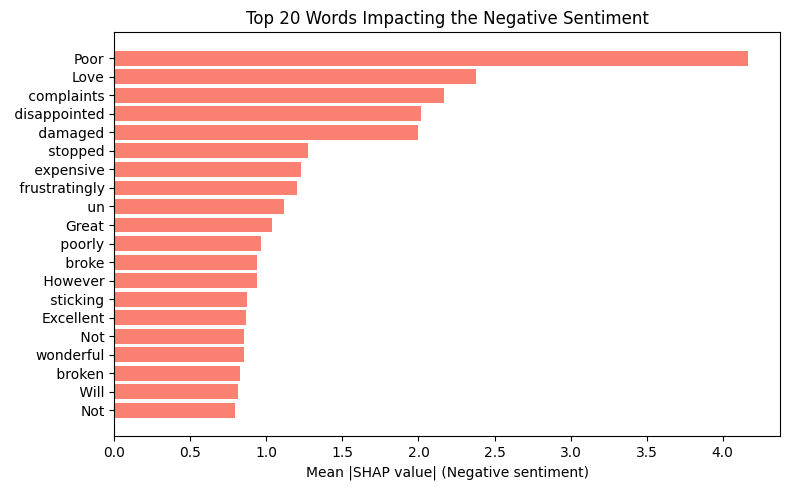

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

NEGATIVE_CLASS_INDEX = 0  # 0 = Negative, 1 = Neutral, 2 = Positive

# Get the SHAP values and tokens for all reviews
shap_vals = shap_values.values     # shape: (num_tokens, num_classes) or list of arrays
tokens = shap_values.data          # list of token lists, one per review

# Check structure and group by review
print("shap_vals type:", type(shap_vals))
print("tokens type:", type(tokens))
print("First shap_vals shape:", shap_vals[0].shape if isinstance(shap_vals[0], np.ndarray) else "not array")
print("First tokens:", tokens[0])

# Aggregate SHAP for Negative class per token
token_to_shaps = defaultdict(list)

for review_shap, review_tokens in zip(shap_vals, tokens):
    # For each review: review_shap shape = (num_tokens, num_classes)
    if len(review_shap.shape) == 2:
        shap_neg = review_shap[:, NEGATIVE_CLASS_INDEX]
    else:
        shap_neg = review_shap
    for token, shap_value in zip(review_tokens, shap_neg):
        token_to_shaps[token].append(np.abs(shap_value))

# Compute mean absolute SHAP value for each token
token_mean_abs_shap = {token: np.mean(shaps) for token, shaps in token_to_shaps.items()}

# Plot top 20
top_n = 20
sorted_tokens = sorted(token_mean_abs_shap, key=token_mean_abs_shap.get, reverse=True)[:top_n]
sorted_shap_vals = [token_mean_abs_shap[token] for token in sorted_tokens]

plt.figure(figsize=(8, 5))
plt.barh(range(top_n), sorted_shap_vals[::-1], color='salmon')
plt.yticks(range(top_n), [sorted_tokens[i] for i in range(top_n)][::-1])
plt.xlabel("Mean |SHAP value| (Negative sentiment)")
plt.title(f"Top {top_n} Words Impacting the Negative Sentiment")
plt.tight_layout()
plt.show()
